# Разработка алгоритма термодинамических расчетов

Ноутбук для разработки и тестирования алгоритмов расчета термодинамических реакций.

## Цель
Загрузить сырые данные веществ из двух сессий расчетов и проанализировать их для разработки алгоритма.

## 1. Импорт библиотек

In [11]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import sqlite3

# Добавляем корень проекта в путь
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.thermo_agents.search.database_connector import DatabaseConnector
from src.thermo_agents.search.sql_builder import SQLBuilder
from src.thermo_agents.search.compound_searcher import CompoundSearcher

print("✓ Библиотеки импортированы")

✓ Библиотеки импортированы


## 2. Подключение к базе данных

In [12]:
# Путь к базе данных
db_path = project_root / "data" / "thermo_data.db"

if not db_path.exists():
    raise FileNotFoundError(f"База данных не найдена: {db_path}")

# Инициализация компонентов
db_connector = DatabaseConnector(db_path)
sql_builder = SQLBuilder()
searcher = CompoundSearcher(sql_builder, db_connector)

print(f"✓ База данных подключена: {db_path}")
print(f"✓ Размер БД: {db_path.stat().st_size / (1024*1024):.2f} МБ")

✓ База данных подключена: c:\IDE\repository\agents_for_david\data\thermo_data.db
✓ Размер БД: 57.08 МБ


## 3. Парсинг логов и извлечение данных LLM

Автоматическая загрузка всех логов из директории `logs/sessions/`

In [13]:
import json
import re

def extract_llm_response_from_log(log_file_path: Path) -> dict:
    """
    Извлечь Raw response (JSON) из лог-файла сессии.
    
    Args:
        log_file_path: Путь к файлу лога
        
    Returns:
        Словарь с данными LLM ответа
    """
    with open(log_file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Ищем блок "Raw response (JSON):" до "Extracted parameters:"
    pattern = r'Raw response \(JSON\):\s*(\{.*?\n\})\s*\nExtracted parameters:'
    match = re.search(pattern, content, re.DOTALL)
    
    if not match:
        raise ValueError(f"Не найден Raw response (JSON) в файле {log_file_path}")
    
    # Получаем JSON строку
    json_str = match.group(1)
    
    try:
        data = json.loads(json_str)
        return data
    except json.JSONDecodeError as e:
        print(f"⚠ Ошибка парсинга JSON: {e}")
        print(f"JSON строка (первые 500 символов):\n{json_str[:500]}")
        raise

In [25]:
# Получаем все логи из директории sessions
logs_dir = project_root / "logs" / "sessions"
log_files = sorted(logs_dir.glob("session_*.log"))

print(f"✓ Найдено {len(log_files)} лог-файлов:")
for log_file in log_files:
    print(f"  - {log_file.name}")

# Извлекаем данные из всех логов
all_logs_data = {}
for log_file in log_files:
    try:
        data = extract_llm_response_from_log(log_file)
        all_logs_data[log_file.stem] = data
        print(f"✓ {log_file.name}: извлечены данные для {len(data.get('all_compounds', []))} веществ")
    except Exception as e:
        print(f"⚠ {log_file.name}: ошибка извлечения - {e}")

print(f"\n✓ Всего успешно обработано логов: {len(all_logs_data)}")

✓ Найдено 6 лог-файлов:
  - session_20251031_213630_5a2a61.log
  - session_20251031_213828_e05bf5.log
  - session_20251102_153753_e40c32.log
  - session_20251102_153840_c2dc29.log
  - session_20251102_153934_02c8ce.log
  - session_20251102_154052_91f384.log
✓ session_20251031_213630_5a2a61.log: извлечены данные для 3 веществ
✓ session_20251031_213828_e05bf5.log: извлечены данные для 4 веществ
✓ session_20251102_153753_e40c32.log: извлечены данные для 4 веществ
✓ session_20251102_153840_c2dc29.log: извлечены данные для 5 веществ
✓ session_20251102_153934_02c8ce.log: извлечены данные для 4 веществ
✓ session_20251102_154052_91f384.log: извлечены данные для 4 веществ

✓ Всего успешно обработано логов: 6


### 3.1. Просмотр извлеченных данных из всех логов

In [26]:
for session_name, llm_data in all_logs_data.items():
    print("=" * 70)
    print(f"СЕССИЯ: {session_name}")
    print("=" * 70)
    print(f"Уравнение: {llm_data.get('balanced_equation', 'N/A')}")
    print(f"Все вещества: {llm_data.get('all_compounds', [])}")
    print(f"\nИмена соединений (compound_names):")
    for formula, names in llm_data.get('compound_names', {}).items():
        print(f"  {formula}: {names}")
    print()

СЕССИЯ: session_20251031_213630_5a2a61
Уравнение: MgO + SO2 → MgSO3
Все вещества: ['MgO', 'SO2', 'MgSO3']

Имена соединений (compound_names):
  MgO: ['Magnesium oxide', 'Magnesia']
  SO2: ['Sulfur dioxide']
  MgSO3: ['Magnesium sulfite']

СЕССИЯ: session_20251031_213828_e05bf5
Уравнение: Al2O3 + 3CaF2 → 2AlF3 + 3CaO
Все вещества: ['Al2O3', 'CaF2', 'AlF3', 'CaO']

Имена соединений (compound_names):
  Al2O3: ['Aluminium oxide', 'Alumina', 'Corundum']
  CaF2: ['Calcium fluoride', 'Fluorite']
  AlF3: ['Aluminium fluoride']
  CaO: ['Calcium oxide', 'Quicklime']

СЕССИЯ: session_20251102_153753_e40c32
Уравнение: Fe2O3 + 3CO → 2Fe + 3CO2
Все вещества: ['Fe2O3', 'CO', 'Fe', 'CO2']

Имена соединений (compound_names):
  Fe2O3: ['Iron(III) oxide', 'Ferric oxide', 'Hematite']
  CO: ['Carbon monoxide', 'Угарный газ']
  Fe: ['Iron', 'Железо']
  CO2: ['Carbon dioxide', 'Диоксид углерода']

СЕССИЯ: session_20251102_153840_c2dc29
Уравнение: 3CuO + 2NH3 → 3Cu + N2 + 3H2O
Все вещества: ['CuO', 'NH3', 'Cu

In [16]:
def get_raw_compound_data(formula: str, compound_names: list = None) -> pd.DataFrame:
    """
    Получить все сырые записи соединения из базы данных без фильтрации.
    
    Двухстадийный поиск:
    1. Поиск по формуле + первое имя из compound_names (строгое соответствие)
    2. Если не найдено - поиск только по формуле (fallback)
    
    Args:
        formula: Химическая формула соединения
        compound_names: Список имен соединения из LLM response (опционально)
        
    Returns:
        DataFrame со всеми найденными записей
    """
    db_connector.connect()
    
    # СТАДИЯ 1: Поиск по формуле + первое имя (строгое соответствие)
    if compound_names and len(compound_names) > 0:
        first_name = compound_names[0]
        query_stage1 = f"""
        SELECT * FROM compounds
        WHERE (
            (TRIM(Formula) = '{formula}' OR Formula LIKE '{formula}(%')
            AND (TRIM(FirstName) = '{first_name}' OR TRIM(SecondName) = '{first_name}')
        )
        AND (Formula NOT LIKE '%+%' AND Formula NOT LIKE '%-%')
        ORDER BY 
            CASE ReliabilityClass 
                WHEN 1 THEN 0 WHEN 2 THEN 1 WHEN 3 THEN 2 
                WHEN 0 THEN 3 WHEN 4 THEN 4 WHEN 5 THEN 5 ELSE 6 
            END,
            (Tmax - Tmin) DESC,
            LENGTH(TRIM(Formula)) ASC,
            CASE Phase 
                WHEN 'g' THEN 0 WHEN 'l' THEN 1 
                WHEN 's' THEN 2 WHEN 'aq' THEN 3 ELSE 4 
            END,
            rowid ASC
        """
        
        results = db_connector.execute_query(query_stage1)
        
        if results:
            df = pd.DataFrame(results)
            print(f"✓ {formula} (стадия 1: формула + '{first_name}'): найдено {len(df)} записей")
            return df
        else:
            print(f"  {formula}: стадия 1 (формула + имя) не дала результатов, переход к стадии 2...")
    
    # СТАДИЯ 2: Fallback - поиск только по формуле
    query_stage2 = f"""
    SELECT * FROM compounds
    WHERE (TRIM(Formula) = '{formula}' OR Formula LIKE '{formula}(%')
    AND (Formula NOT LIKE '%+%' AND Formula NOT LIKE '%-%')
    ORDER BY 
        CASE ReliabilityClass 
            WHEN 1 THEN 0 WHEN 2 THEN 1 WHEN 3 THEN 2 
            WHEN 0 THEN 3 WHEN 4 THEN 4 WHEN 5 THEN 5 ELSE 6 
        END,
        (Tmax - Tmin) DESC,
        LENGTH(TRIM(Formula)) ASC,
        CASE Phase 
            WHEN 'g' THEN 0 WHEN 'l' THEN 1 
            WHEN 's' THEN 2 WHEN 'aq' THEN 3 ELSE 4 
        END,
        rowid ASC
    """
    
    results = db_connector.execute_query(query_stage2)
    
    if not results:
        print(f"⚠ {formula}: не найдено записей (обе стадии)")
        return pd.DataFrame()
    
    df = pd.DataFrame(results)
    print(f"✓ {formula} (стадия 2: только формула): найдено {len(df)} записей")
    
    return df

### 3.2. Загрузка данных для всех сессий

Используем данные из JSON ответа LLM для улучшенного поиска.

In [28]:
# Создаем словарь для хранения данных всех сессий
all_sessions_data = {}

for session_name, llm_data in all_logs_data.items():
    print(f"\n{'=' * 70}")
    print(f"Загрузка данных для сессии: {session_name}")
    print("=" * 70)
    
    session_data = {}
    compound_names_dict = llm_data.get('compound_names', {})
    
    for formula in llm_data.get('all_compounds', []):
        names = compound_names_dict.get(formula, None)
        session_data[formula] = get_raw_compound_data(formula, names)
    
    all_sessions_data[session_name] = session_data
    
    # Сводка по сессии
    print(f"\nСводка по {session_name}:")
    for formula, df in session_data.items():
        phases = df['Phase'].unique() if len(df) > 0 else []
        print(f"  {formula}: {len(df)} записей, фазы: {list(phases)}")


Загрузка данных для сессии: session_20251031_213630_5a2a61
✓ MgO (стадия 1: формула + 'Magnesium oxide'): найдено 71 записей
✓ SO2 (стадия 1: формула + 'Sulfur dioxide'): найдено 1010 записей
✓ MgSO3 (стадия 1: формула + 'Magnesium sulfite'): найдено 12 записей

Сводка по session_20251031_213630_5a2a61:
  MgO: 71 записей, фазы: ['g', 's', 'l']
  SO2: 1010 записей, фазы: ['g', 'l', 'a', 'ao']
  MgSO3: 12 записей, фазы: ['a', 'ai', 's']

Загрузка данных для сессии: session_20251031_213828_e05bf5
  Al2O3: стадия 1 (формула + имя) не дала результатов, переход к стадии 2...
✓ Al2O3 (стадия 2: только формула): найдено 100 записей
✓ CaF2 (стадия 1: формула + 'Calcium fluoride'): найдено 79 записей
✓ AlF3 (стадия 1: формула + 'Aluminium fluoride'): найдено 30 записей
✓ CaO (стадия 1: формула + 'Calcium oxide'): найдено 85 записей

Сводка по session_20251031_213828_e05bf5:
  Al2O3: 100 записей, фазы: ['g', 'l', 's']
  CaF2: 79 записей, фазы: ['g', 'l', 's', 'ai']
  AlF3: 30 записей, фазы: ['s'

## 4. Итоговая сводка

Данные загружены с использованием улучшенного двухстадийного алгоритма поиска.

In [30]:
print("=" * 70)
print("ИТОГОВАЯ СВОДКА ПО ВСЕМ ЗАГРУЖЕННЫМ ДАННЫМ")
print("=" * 70)

total_records_all = 0

for session_name, session_data in all_sessions_data.items():
    llm_data = all_logs_data[session_name]
    
    print(f"\n📊 СЕССИЯ: {session_name}")
    print(f"   Уравнение из LLM: {llm_data.get('balanced_equation', 'N/A')}")
    
    total_session = sum(len(df) for df in session_data.values())
    total_records_all += total_session
    print(f"   Всего записей: {total_session}")
    
    for formula, df in session_data.items():
        names = llm_data.get('compound_names', {}).get(formula, [])
        first_name = names[0] if names else "N/A"
        phases = df['Phase'].unique() if len(df) > 0 else []
        print(f"   - {formula} ({first_name}): {len(df)} записей, фазы: {list(phases)}")

print("\n" + "=" * 70)
print(f"✓ Всего обработано сессий: {len(all_sessions_data)}")
print(f"✓ Общее количество загруженных записей: {total_records_all}")
print("✓ Данные доступны в переменной: all_sessions_data")
print("✓ Метаданные из LLM доступны в: all_logs_data")
print("=" * 70)

ИТОГОВАЯ СВОДКА ПО ВСЕМ ЗАГРУЖЕННЫМ ДАННЫМ

📊 СЕССИЯ: session_20251031_213630_5a2a61
   Уравнение из LLM: MgO + SO2 → MgSO3
   Всего записей: 1093
   - MgO (Magnesium oxide): 71 записей, фазы: ['g', 's', 'l']
   - SO2 (Sulfur dioxide): 1010 записей, фазы: ['g', 'l', 'a', 'ao']
   - MgSO3 (Magnesium sulfite): 12 записей, фазы: ['a', 'ai', 's']

📊 СЕССИЯ: session_20251031_213828_e05bf5
   Уравнение из LLM: Al2O3 + 3CaF2 → 2AlF3 + 3CaO
   Всего записей: 294
   - Al2O3 (Aluminium oxide): 100 записей, фазы: ['g', 'l', 's']
   - CaF2 (Calcium fluoride): 79 записей, фазы: ['g', 'l', 's', 'ai']
   - AlF3 (Aluminium fluoride): 30 записей, фазы: ['s', 'l']
   - CaO (Calcium oxide): 85 записей, фазы: ['g', 'l', 's']

📊 СЕССИЯ: session_20251102_153753_e40c32
   Уравнение из LLM: Fe2O3 + 3CO → 2Fe + 3CO2
   Всего записей: 1536
   - Fe2O3 (Iron(III) oxide): 56 записей, фазы: ['l', 's']
   - CO (Carbon monoxide): 46 записей, фазы: ['g', 'ao', 'a']
   - Fe (Iron): 95 записей, фазы: ['g', 'l', 's']
   

## 5. Вспомогательные функции для термодинамических расчетов

In [20]:
def get_most_common_melting_boiling_points(df: pd.DataFrame) -> tuple:
    """
    Возвращает самое частое ненулевое значение MeltingPoint и BoilingPoint из DataFrame.
    Фильтрует некорректные значения: boiling_point должен быть больше melting_point.
    
    Args:
        df: DataFrame с данными вещества
        
    Returns:
        tuple: (melting_point, boiling_point) или (None, None)
    """
    melting_point = df[df['MeltingPoint'] != 0]['MeltingPoint'].value_counts().idxmax() if (df['MeltingPoint'] != 0).any() else None
    
    # Для boiling_point фильтруем только те значения, которые больше melting_point
    if melting_point is not None:
        boiling_candidates = df[(df['BoilingPoint'] != 0) & (df['BoilingPoint'] > melting_point)]['BoilingPoint']
    else:
        boiling_candidates = df[df['BoilingPoint'] != 0]['BoilingPoint']
    
    boiling_point = boiling_candidates.value_counts().idxmax() if len(boiling_candidates) > 0 else None
    
    return melting_point, boiling_point

print("✓ Функция get_most_common_melting_boiling_points определена")

✓ Функция get_most_common_melting_boiling_points определена


In [21]:
def calculate_thermodynamic_properties(row, T):
    """
    Расчет термодинамических свойств вещества при заданной температуре.
    
    Args:
        row: Строка DataFrame с коэффициентами и базовыми свойствами
        T: Температура в K
        
    Returns:
        tuple: (cp, enthalpy, entropy, gibbs_energy)
    """
    T = float(T)  # Ensure T is a float to allow negative powers
    T_ref = 298.15  # Reference temperature in K

    if 'Tmin' in row and 'Tmax' in row:
        if T < row['Tmin'] or T > row['Tmax']:
            print(f"Предупреждение: Температура {T} K выходит за пределы допустимого диапазона {row['Tmin']}-{row['Tmax']} K для вещества {row.get('Formula', '')}")

    # Coefficients for heat capacity calculation
    f1 = row['f1'] if 'f1' in row else 0
    f2 = row['f2'] if 'f2' in row else 0
    f3 = row['f3'] if 'f3' in row else 0
    f4 = row['f4'] if 'f4' in row else 0
    f5 = row['f5'] if 'f5' in row else 0
    f6 = row['f6'] if 'f6' in row else 0
    H298 = row['H298'] if 'H298' in row else 0
    S298 = row['S298'] if 'S298' in row else 0

    # Function to calculate Cp at any temperature
    def cp_function(temp):
        return (f1 + f2*temp/1000 + f3*temp**(-2) * 100_000 + 
                f4*temp**2 / 1_000_000 + f5*temp**(-3) * 1_000 + 
                f6*temp**3 * 10**(-9))

    # Current temperature heat capacity
    cp = cp_function(T)

    # If T equals reference temperature, no need for integration
    if abs(T - T_ref) < 1e-6:
        return cp, H298 * 1000, S298, H298 * 1000 - T*S298

    # Numerical integration for enthalpy change (ΔH)
    # ΔH = ∫(T_ref to T) Cp(T) dT
    num_points = 100  # Number of points for numerical integration
    temp_points = np.linspace(T_ref, T, num_points)
    cp_values = np.array([cp_function(t) for t in temp_points])
    delta_H = np.trapz(cp_values, temp_points)

    # Numerical integration for entropy change (ΔS)
    # ΔS = ∫(T_ref to T) Cp(T)/T dT
    cp_over_T = cp_values / temp_points
    delta_S = np.trapz(cp_over_T, temp_points)

    # Calculate final enthalpy and entropy
    enthalpy = H298 * 1000 + delta_H  # Convert H298 from kJ to J
    entropy = S298 + delta_S

    # Calculate Gibbs free energy
    gibbs_energy = enthalpy - T * entropy

    return cp, enthalpy, entropy, gibbs_energy

print("✓ Функция calculate_thermodynamic_properties определена")

✓ Функция calculate_thermodynamic_properties определена


In [61]:
def get_compound_records_for_range(df, t_range, melting, boiling, tolerance=1):
    """
    Возвращает список записей вещества, покрывающих весь температурный диапазон t_range.
    
    При достижении температуры фазового перехода (плавление/кипение) автоматически
    переключается на соответствующую фазу и продолжает поиск с температуры перехода.
    
    Трёхуровневая стратегия поиска записей:
    1. Ищем запись ожидаемой фазы с Tmin ≈ current_T (±tolerance)
    2. Если не найдено - ищем любую запись с Tmin ≈ current_T, >50% в правильной фазе
    3. Если не найдено - ищем запись, которая ПОКРЫВАЕТ current_T (Tmin < current_T < Tmax)
    
    Args:
        df: DataFrame с данными вещества из БД
        t_range: Список [T_start, T_end] - начальная и конечная температура диапазона
        melting: Температура плавления (MeltingPoint) или None
        boiling: Температура кипения (BoilingPoint) или None
        tolerance: Допустимое отклонение при поиске записи по Tmin (по умолчанию 1K)
        
    Returns:
        List[pd.Series]: Список записей (строк DataFrame), покрывающих весь диапазон
    """
    
    def get_phase_at_temperature(T, melting, boiling):
        """Определяет ожидаемую фазу при заданной температуре."""
        if boiling and T >= boiling:
            return 'g'
        elif melting and T >= melting:
            return 'l'
        else:
            return 's'
    
    def get_dominant_phase(record, melting, boiling):
        """
        Определяет доминирующую фазу для записи на основе температурного диапазона.
        Возвращает фазу, в которой запись находится >50% времени.
        """
        tmin = record['Tmin']
        tmax = record['Tmax']
        total_range = tmax - tmin
        
        # Разбиваем диапазон по фазовым переходам
        phase_ranges = {
            's': 0,
            'l': 0,
            'g': 0
        }
        
        # Вычисляем длительность в каждой фазе
        current_t = tmin
        
        while current_t < tmax:
            # Определяем фазу при current_t
            phase = get_phase_at_temperature(current_t, melting, boiling)
            
            # Определяем конец текущего фазового сегмента
            if phase == 's' and melting and melting < tmax:
                segment_end = min(melting, tmax)
            elif phase == 'l' and boiling and boiling < tmax:
                segment_end = min(boiling, tmax)
            else:
                segment_end = tmax
            
            # Добавляем длительность сегмента
            phase_ranges[phase] += (segment_end - current_t)
            current_t = segment_end
        
        # Находим доминирующую фазу (>50%)
        for phase, duration in phase_ranges.items():
            if duration > total_range / 2:
                return phase
        
        # Если нет явного доминирования (50/50), возвращаем фазу начала диапазона
        return get_phase_at_temperature(tmin, melting, boiling)
    
    def get_phase_fraction_from_T(record, start_T, melting, boiling):
        """
        Вычисляет, какая доля диапазона записи [start_T, Tmax] находится в фазе записи.
        Используется для СТРАТЕГИИ 3, когда запись начинается раньше current_T.
        """
        tmin = max(start_T, record['Tmin'])  # Начинаем с start_T или Tmin записи
        tmax = record['Tmax']
        record_phase = record['Phase']
        
        if tmin >= tmax:
            return 0.0
        
        total_range = tmax - tmin
        phase_duration = 0.0
        
        current_t = tmin
        while current_t < tmax:
            phase_at_t = get_phase_at_temperature(current_t, melting, boiling)
            
            # Определяем конец текущего фазового сегмента
            if phase_at_t == 's' and melting and melting < tmax:
                segment_end = min(melting, tmax)
            elif phase_at_t == 'l' and boiling and boiling < tmax:
                segment_end = min(boiling, tmax)
            else:
                segment_end = tmax
            
            # Если фаза совпадает с фазой записи, добавляем длительность
            if phase_at_t == record_phase:
                phase_duration += (segment_end - current_t)
            
            current_t = segment_end
        
        return phase_duration / total_range if total_range > 0 else 0.0
    
    records = []
    current_T = t_range[0]
    target_T = t_range[1]
    last_phase = None
    
    while current_T < target_T:
        # Определяем текущую ожидаемую фазу на основе температуры
        expected_phase = get_phase_at_temperature(current_T, melting, boiling)
        
        # СТРАТЕГИЯ 1: Ищем запись для ожидаемой фазы, начинающуюся с current_T
        matching_records = df[
            (df['Phase'] == expected_phase) & 
            (df['Tmin'] <= current_T + tolerance) & 
            (df['Tmin'] >= current_T - tolerance)
        ]
        
        if not matching_records.empty:
            # Нашли запись для ожидаемой фазы
            record = matching_records.iloc[0]
            records.append(record)
            last_phase = expected_phase
        else:
            # СТРАТЕГИЯ 2: Не найдена запись для ожидаемой фазы
            # Ищем любую запись, которая начинается с current_T
            candidates = df[
                (df['Tmin'] <= current_T + tolerance) & 
                (df['Tmin'] >= current_T - tolerance)
            ]
            
            valid_candidates = []
            
            if not candidates.empty:
                # Фильтруем кандидатов по критериям:
                # 1. Доминирующая фаза должна быть корректной (>50% в правильной фазе)
                # 2. Не допускаем некорректных переходов (например, s → g без l)
                
                for idx, candidate in candidates.iterrows():
                    dominant_phase = get_dominant_phase(candidate, melting, boiling)
                    candidate_phase = candidate['Phase']
                    
                    # Проверка корректности последовательности фаз
                    if last_phase is not None:
                        # Не допускаем пропуск фаз (например, s → g)
                        phase_order = {'s': 0, 'l': 1, 'g': 2}
                        if last_phase in phase_order and candidate_phase in phase_order:
                            # Разрешаем только переход на следующую фазу или ту же
                            if phase_order[candidate_phase] > phase_order[last_phase] + 1:
                                continue  # Пропускаем этого кандидата
                    
                    # Проверка: >50% диапазона в корректной фазе
                    if dominant_phase == candidate_phase:
                        valid_candidates.append((idx, candidate, dominant_phase, 2))  # Приоритет 2 для стратегии 2
            
            # СТРАТЕГИЯ 3: Ищем запись, которая ПОКРЫВАЕТ current_T
            # (используется когда нет записи, начинающейся с current_T)
            if not valid_candidates:
                covering_candidates = df[
                    (df['Tmin'] < current_T) & 
                    (df['Tmax'] > current_T)
                ]
                
                for idx, candidate in covering_candidates.iterrows():
                    candidate_phase = candidate['Phase']
                    
                    # Проверка корректности последовательности фаз
                    if last_phase is not None:
                        phase_order = {'s': 0, 'l': 1, 'g': 2}
                        if last_phase in phase_order and candidate_phase in phase_order:
                            if phase_order[candidate_phase] > phase_order[last_phase] + 1:
                                continue
                    
                    # Проверка: >50% ОСТАВШЕГОСЯ диапазона [current_T, Tmax] в правильной фазе
                    phase_fraction = get_phase_fraction_from_T(candidate, current_T, melting, boiling)
                    
                    if phase_fraction > 0.5:
                        valid_candidates.append((idx, candidate, candidate_phase, 3))  # Приоритет 3 для стратегии 3
            
            if not valid_candidates:
                print(f"⚠ Не найдена подходящая запись для продолжения диапазона при T={current_T} K")
                print(f"   Ожидаемая фаза: {expected_phase}, последняя фаза: {last_phase}")
                break
            
            # Сортируем кандидатов по приоритету (меньше = лучше)
            valid_candidates.sort(key=lambda x: x[3])
            
            # Берём лучшего кандидата
            idx, record, phase_info, strategy = valid_candidates[0]
            records.append(record)
            last_phase = record['Phase']
            
            if strategy == 2:
                print(f"  [Стратегия 2] Использована запись фазы '{record['Phase']}' (доминирует {phase_info}) при T={current_T} K")
            elif strategy == 3:
                print(f"  [Стратегия 3] Использована покрывающая запись фазы '{record['Phase']}' (Tmin={record['Tmin']}, покрывает T={current_T} K)")
        
        # Определяем следующую температуру
        record_tmax = record['Tmax']
        
        # Проверяем, достигли ли мы точки фазового перехода внутри текущей записи
        next_transition = None
        if melting and current_T < melting <= record_tmax:
            next_transition = melting
        elif boiling and current_T < boiling <= record_tmax:
            next_transition = boiling
        
        if next_transition:
            # Фазовый переход внутри текущей записи
            print(f"  Фазовый переход при T={next_transition} K внутри записи {last_phase}")
            current_T = record_tmax
            
            # Если достигли или превысили целевую температуру, завершаем
            if current_T >= target_T:
                break
        else:
            # Переход к следующей записи
            current_T = record_tmax
            
            # Если достигли или превысили целевую температуру, завершаем
            if current_T >= target_T:
                break
    
    return records

print("✓ Функция get_compound_records_for_range определена")

✓ Функция get_compound_records_for_range определена


## 6. Пример использования функций

Тестируем функции на данных из первой доступной сессии.

In [33]:
# Выбираем первую сессию для примера
if all_sessions_data:
    first_session_name = list(all_sessions_data.keys())[0]
    first_session_data = all_sessions_data[first_session_name]
    
    # Выбираем первое вещество из сессии
    if first_session_data:
        test_formula = list(first_session_data.keys())[0]
        test_compound_df = first_session_data[test_formula]
        
        if not test_compound_df.empty:
            # Определяем точки фазовых переходов
            melting, boiling = get_most_common_melting_boiling_points(test_compound_df)
            
            print("=" * 70)
            print(f"АНАЛИЗ {test_formula} (из сессии {first_session_name})")
            print("=" * 70)
            print(f"Точки фазовых переходов:")
            print(f"  Плавление: {melting} K" if melting else "  Плавление: не определено")
            print(f"  Кипение: {boiling} K" if boiling else "  Кипение: не определено")
            print(f"\nВсего записей в БД: {len(test_compound_df)}")
            print(f"Фазы: {list(test_compound_df['Phase'].unique())}")
        else:
            print(f"⚠ Данные для {test_formula} не найдены")
    else:
        print("⚠ Нет данных в первой сессии")
else:
    print("⚠ Нет загруженных сессий")

АНАЛИЗ MgO (из сессии session_20251031_213630_5a2a61)
Точки фазовых переходов:
  Плавление: 3105.0 K
  Кипение: 3873.0 K

Всего записей в БД: 71
Фазы: ['g', 's', 'l']


In [77]:
df = all_sessions_data['session_20251102_153934_02c8ce']['SO2']
t_range = [298, 2500]
melting, boiling = get_most_common_melting_boiling_points(df)
compound_records = get_compound_records_for_range(df, t_range, melting, boiling)

print(f"\n✓ Найдено {len(compound_records)} записей:")
for i, record in enumerate(compound_records, 1):
    print(f"  {i}. Фаза: {record['Phase']}, Tmin: {record['Tmin']} K, Tmax: {record['Tmax']} K")


  [Стратегия 2] Использована запись фазы 'g' (доминирует g) при T=298 K
  Фазовый переход при T=423.6 K внутри записи g

✓ Найдено 3 записей:
  1. Фаза: g, Tmin: 298.15 K, Tmax: 700.0 K
  2. Фаза: g, Tmin: 700.0 K, Tmax: 2000.0 K
  3. Фаза: g, Tmin: 2000.0 K, Tmax: 3000.0 K


## 7. Расчет термодинамических свойств реакций для всех сессий

Для каждой сессии выполняем расчет ΔH, ΔS, ΔG реакции и константы равновесия в диапазоне 298-2500 K с шагом 100 K.

In [82]:
def parse_reaction_equation(equation: str, all_compounds: list) -> dict:
    """
    Парсит уравнение реакции и извлекает стехиометрические коэффициенты.
    
    Args:
        equation: Сбалансированное уравнение реакции
        all_compounds: Список всех формул соединений
        
    Returns:
        dict: {formula: coefficient}, где положительные - продукты, отрицательные - реактанты
    """
    import re
    
    # Разделяем на левую и правую части
    # Поддерживаем оба формата: '=' и '→'
    if '=' in equation:
        left, right = equation.split('=')
    elif '→' in equation:
        left, right = equation.split('→')
    elif '->' in equation:
        left, right = equation.split('->')
    else:
        raise ValueError(f"Уравнение должно содержать '=' или '→': {equation}")
    
    def parse_side(side_str: str, all_compounds: list) -> dict:
        """Парсит одну сторону уравнения."""
        coeffs = {}
        side_str = side_str.strip()
        
        # Создаем regex паттерн для поиска всех соединений
        # Сортируем по длине (сначала длинные), чтобы избежать ложных совпадений
        sorted_compounds = sorted(all_compounds, key=len, reverse=True)
        
        for compound in sorted_compounds:
            # Экранируем спецсимволы в формуле
            escaped_compound = re.escape(compound)
            # Паттерн: опциональный коэффициент + формула + граница слова
            pattern = r'(\d*\.?\d*)\s*' + escaped_compound + r'(?:\s|$|\+)'
            
            matches = re.finditer(pattern, side_str)
            
            for match in matches:
                coeff_str = match.group(1).strip()
                coeff = float(coeff_str) if coeff_str else 1.0
                
                if compound in coeffs:
                    coeffs[compound] += coeff
                else:
                    coeffs[compound] = coeff
        
        return coeffs
    
    # Парсим обе стороны
    left_coeffs = parse_side(left, all_compounds)
    right_coeffs = parse_side(right, all_compounds)
    
    # Объединяем: реактанты (левая сторона) - отрицательные, продукты (правая) - положительные
    reaction_coeffs = {}
    
    for compound, coeff in left_coeffs.items():
        reaction_coeffs[compound] = -coeff
    
    for compound, coeff in right_coeffs.items():
        if compound in reaction_coeffs:
            reaction_coeffs[compound] += coeff
        else:
            reaction_coeffs[compound] = coeff
    
    return reaction_coeffs

print("✓ Функция parse_reaction_equation определена")

✓ Функция parse_reaction_equation определена


In [80]:
def calculate_reaction_thermodynamics(session_name: str, session_data: dict, llm_data: dict, 
                                      temperature_range: list) -> pd.DataFrame:
    """
    Рассчитывает термодинамические свойства реакции для заданного диапазона температур.
    
    Args:
        session_name: Название сессии
        session_data: Данные веществ из БД (словарь {formula: DataFrame})
        llm_data: Метаданные из LLM ответа
        temperature_range: [T_start, T_end, step] - диапазон температур
        
    Returns:
        DataFrame с колонками: T, ΔH, ΔS, ΔG, ln(K), K
    """
    R = 8.314  # Универсальная газовая постоянная, Дж/(моль·K)
    
    # Парсим уравнение реакции
    equation = llm_data.get('balanced_equation', '')
    all_compounds = llm_data.get('all_compounds', [])
    
    try:
        reaction_coeffs = parse_reaction_equation(equation, all_compounds)
    except Exception as e:
        print(f"⚠ Ошибка парсинга уравнения '{equation}': {e}")
        return pd.DataFrame()
    
    print(f"\n{'='*70}")
    print(f"РАСЧЕТ РЕАКЦИИ: {session_name}")
    print(f"Уравнение: {equation}")
    print(f"Стехиометрия: {reaction_coeffs}")
    print('='*70)
    
    # Подготовка данных для каждого вещества
    compound_data = {}
    
    for formula in all_compounds:
        df = session_data.get(formula, pd.DataFrame())
        
        if df.empty:
            print(f"⚠ {formula}: нет данных в БД")
            continue
        
        # Определяем точки фазовых переходов
        melting, boiling = get_most_common_melting_boiling_points(df)
        
        # Получаем записи для полного диапазона
        t_range_full = [temperature_range[0], temperature_range[1]]
        records = get_compound_records_for_range(df, t_range_full, melting, boiling)
        
        if not records:
            print(f"⚠ {formula}: не удалось получить записи для диапазона")
            continue
        
        compound_data[formula] = {
            'records': records,
            'melting': melting,
            'boiling': boiling,
            'coeff': reaction_coeffs.get(formula, 0)
        }
        
        print(f"✓ {formula}: подготовлено {len(records)} записей, coeff={reaction_coeffs.get(formula, 0)}")
    
    # Расчет для каждой температуры
    results = []
    
    T_start, T_end, T_step = temperature_range
    temperatures = np.arange(T_start, T_end + T_step, T_step)
    
    for T in temperatures:
        delta_H = 0.0
        delta_S = 0.0
        
        for formula, data in compound_data.items():
            coeff = data['coeff']
            records = data['records']
            
            # Находим подходящую запись для текущей температуры
            suitable_record = None
            for record in records:
                if record['Tmin'] <= T <= record['Tmax']:
                    suitable_record = record
                    break
            
            if suitable_record is None:
                print(f"⚠ T={T} K: нет подходящей записи для {formula}")
                continue
            
            # Рассчитываем термодинамические свойства
            cp, enthalpy, entropy, gibbs = calculate_thermodynamic_properties(suitable_record, T)
            
            # Добавляем вклад в реакцию (с учетом стехиометрии)
            delta_H += coeff * enthalpy
            delta_S += coeff * entropy
        
        # Вычисляем ΔG и константу равновесия
        delta_G = delta_H - T * delta_S
        
        # ln(K) = -ΔG / (R * T)
        ln_K = -delta_G / (R * T) if T > 0 else 0
        K = np.exp(ln_K) if abs(ln_K) < 700 else (np.inf if ln_K > 0 else 0)  # Избегаем overflow
        
        results.append({
            'T (K)': T,
            'ΔH (J/mol)': delta_H,
            'ΔS (J/mol·K)': delta_S,
            'ΔG (J/mol)': delta_G,
            'ln(K)': ln_K,
            'K': K
        })
    
    return pd.DataFrame(results)

print("✓ Функция calculate_reaction_thermodynamics определена")

✓ Функция calculate_reaction_thermodynamics определена


In [83]:
# Выполняем расчеты для всех сессий
temperature_range = [298, 2500, 100]  # T_start, T_end, step

all_results = {}

for session_name, session_data in all_sessions_data.items():
    llm_data = all_logs_data[session_name]
    
    df_result = calculate_reaction_thermodynamics(
        session_name, 
        session_data, 
        llm_data, 
        temperature_range
    )
    
    if not df_result.empty:
        all_results[session_name] = df_result
        
        print(f"\n✓ Расчет завершен для {session_name}")
        print(f"  Рассчитано точек: {len(df_result)}")
    else:
        print(f"\n⚠ Расчет не выполнен для {session_name}")

print(f"\n{'='*70}")
print(f"✓ РАСЧЕТЫ ЗАВЕРШЕНЫ")
print(f"✓ Обработано сессий: {len(all_results)}")
print('='*70)


РАСЧЕТ РЕАКЦИИ: session_20251031_213630_5a2a61
Уравнение: MgO + SO2 → MgSO3
Стехиометрия: {'MgO': -1.0, 'SO2': -1.0, 'MgSO3': 1.0}
  Фазовый переход при T=3105.0 K внутри записи s
✓ MgO: подготовлено 1 записей, coeff=-1.0
  [Стратегия 2] Использована запись фазы 'g' (доминирует g) при T=298 K
  Фазовый переход при T=423.6 K внутри записи g
✓ SO2: подготовлено 3 записей, coeff=-1.0
⚠ Не найдена подходящая запись для продолжения диапазона при T=398.0 K
   Ожидаемая фаза: s, последняя фаза: s
✓ MgSO3: подготовлено 1 записей, coeff=1.0
⚠ T=298 K: нет подходящей записи для MgO
⚠ T=298 K: нет подходящей записи для SO2
⚠ T=298 K: нет подходящей записи для MgSO3
⚠ T=498 K: нет подходящей записи для MgSO3
⚠ T=598 K: нет подходящей записи для MgSO3
⚠ T=698 K: нет подходящей записи для MgSO3
⚠ T=798 K: нет подходящей записи для MgSO3
⚠ T=898 K: нет подходящей записи для MgSO3
⚠ T=998 K: нет подходящей записи для MgSO3
⚠ T=1098 K: нет подходящей записи для MgSO3
⚠ T=1198 K: нет подходящей записи 

C:\Users\davjd\AppData\Local\Temp\ipykernel_16880\3125825576.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  delta_H = np.trapz(cp_values, temp_points)
C:\Users\davjd\AppData\Local\Temp\ipykernel_16880\3125825576.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  delta_S = np.trapz(cp_over_T, temp_points)
C:\Users\davjd\AppData\Local\Temp\ipykernel_16880\3125825576.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  delta_H = np.trapz(cp_values, temp_points)
C:\Users\davjd\AppData\Local\Temp\ipykernel_16880\3125825576.py:52: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  delta_S = np.trapz(cp_over_T, temp_points)
C:\U

### 7.1. Вывод итоговых таблиц для каждой сессии

In [84]:
# Выводим таблицы для каждой сессии
for session_name, df_result in all_results.items():
    llm_data = all_logs_data[session_name]
    equation = llm_data.get('balanced_equation', 'N/A')
    
    print("\n" + "="*80)
    print(f"СЕССИЯ: {session_name}")
    print(f"УРАВНЕНИЕ: {equation}")
    print("="*80)
    
    # Форматируем таблицу для красивого вывода
    df_display = df_result.copy()
    
    # Форматируем числа
    df_display['T (K)'] = df_display['T (K)'].astype(int)
    df_display['ΔH (J/mol)'] = df_display['ΔH (J/mol)'].apply(lambda x: f"{x:.2e}")
    df_display['ΔS (J/mol·K)'] = df_display['ΔS (J/mol·K)'].apply(lambda x: f"{x:.2e}")
    df_display['ΔG (J/mol)'] = df_display['ΔG (J/mol)'].apply(lambda x: f"{x:.2e}")
    df_display['ln(K)'] = df_display['ln(K)'].apply(lambda x: f"{x:.4f}")
    df_display['K'] = df_display['K'].apply(lambda x: f"{x:.2e}" if x != np.inf else "∞")
    
    # Выводим каждые 5 строк (каждые 500 K) + первую и последнюю
    indices_to_show = [0] + list(range(4, len(df_display), 5)) + [len(df_display)-1]
    indices_to_show = sorted(set(indices_to_show))
    
    print(df_display.iloc[indices_to_show].to_string(index=False))
    print(f"\nВсего точек: {len(df_result)}")
    print("="*80)


СЕССИЯ: session_20251031_213630_5a2a61
УРАВНЕНИЕ: MgO + SO2 → MgSO3
 T (K) ΔH (J/mol) ΔS (J/mol·K) ΔG (J/mol)     ln(K)        K
   298   0.00e+00     0.00e+00   0.00e+00   -0.0000 1.00e+00
   698   8.62e+05    -3.51e+02   1.11e+06 -190.7243 1.48e-83
  1198   5.13e+05    -1.57e+02   7.01e+05  -70.4235 2.60e-31
  1698   4.58e+05    -1.95e+02   7.90e+05  -55.9584 4.98e-25
  2198   4.17e+05    -1.89e+02   8.32e+05  -45.5488 1.65e-20
  2598   3.71e+05    -2.08e+02   9.12e+05  -42.2119 4.65e-19

Всего точек: 24

СЕССИЯ: session_20251031_213828_e05bf5
УРАВНЕНИЕ: Al2O3 + 3CaF2 → 2AlF3 + 3CaO
 T (K) ΔH (J/mol) ΔS (J/mol·K) ΔG (J/mol)     ln(K)         K
   298   0.00e+00     0.00e+00   0.00e+00   -0.0000  1.00e+00
   698   3.43e+06    -1.58e+02   3.54e+06 -610.5665 6.83e-266
  1198   3.42e+06    -1.59e+02   3.61e+06 -362.6852 3.07e-158
  1698  -4.16e+05    -1.04e+02  -2.39e+05   16.8988  2.18e+07
  2198  -4.37e+05    -1.15e+02  -1.83e+05   10.0327  2.28e+04
  2598  -9.32e+05    -5.55e+02   5.

### 7.2. Визуализация результатов

Построение графиков зависимости ΔG и ln(K) от температуры для всех реакций.

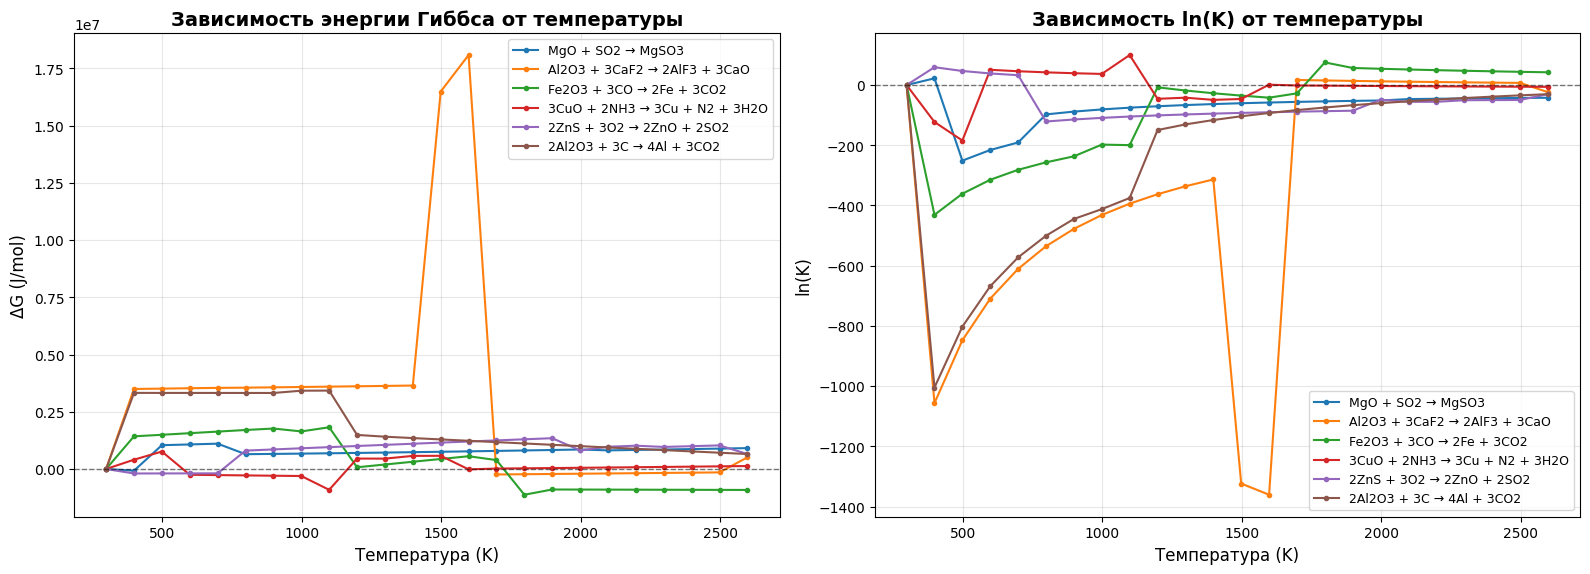

✓ Графики построены


In [85]:
import matplotlib.pyplot as plt

# Создаем фигуру с двумя графиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Цвета для разных сессий
colors = plt.cm.tab10(range(len(all_results)))

for idx, (session_name, df_result) in enumerate(all_results.items()):
    llm_data = all_logs_data[session_name]
    equation = llm_data.get('balanced_equation', 'N/A')
    
    # Сокращаем название для легенды
    label = equation[:40] + '...' if len(equation) > 40 else equation
    
    # График ΔG(T)
    ax1.plot(df_result['T (K)'], df_result['ΔG (J/mol)'], 
             marker='o', markersize=3, linewidth=1.5, 
             color=colors[idx], label=label)
    
    # График ln(K)(T)
    # Фильтруем значения ln(K) для читаемости графика
    ln_k_filtered = df_result['ln(K)'].copy()
    ln_k_filtered = ln_k_filtered.replace([np.inf, -np.inf], np.nan)
    
    ax2.plot(df_result['T (K)'], ln_k_filtered, 
             marker='o', markersize=3, linewidth=1.5, 
             color=colors[idx], label=label)

# Настройка графика ΔG
ax1.set_xlabel('Температура (K)', fontsize=12)
ax1.set_ylabel('ΔG (J/mol)', fontsize=12)
ax1.set_title('Зависимость энергии Гиббса от температуры', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=9, loc='best')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Настройка графика ln(K)
ax2.set_xlabel('Температура (K)', fontsize=12)
ax2.set_ylabel('ln(K)', fontsize=12)
ax2.set_title('Зависимость ln(K) от температуры', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9, loc='best')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

print("✓ Графики построены")